In [1]:
import os
from pprint import pprint
import sys
import json

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')

from sleeprnn.common import viz, constants, pkeys
from sleeprnn.data import utils
from sleeprnn.helpers import reader

viz.notebook_full_width()
%matplotlib inline

In [2]:
dataset = reader.load_dataset(constants.MODA_SS_NAME)

Dataset moda_ss with 180 patients.
Loading from checkpoint... Loaded
Global STD: None


# Visualize single subject

In [ ]:
subject_id = dataset.all_ids[55]
print("Subject id %s" % subject_id)
signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
marks = dataset.get_subject_stamps(subject_id, pages_subset=constants.N2_RECORD)
n2_pages = dataset.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)
print("Signal", signal.shape, signal.dtype)
print("Marks", marks.shape, marks.dtype)
print("N2 pages", n2_pages.shape, n2_pages.dtype)

In [ ]:
def draw_signal(n2_page_loc):
    fig, ax = plt.subplots(1, 1, figsize=(12, 2), dpi=140)

    n2_page_id = n2_pages[n2_page_loc]
    start_sample = int(n2_page_id * dataset.page_size)
    end_sample = int(start_sample + dataset.page_size)
    
    page_signal = signal[start_sample:end_sample]
    page_label = utils.filter_stamps(marks, start_sample=start_sample, end_sample=end_sample)
    
    time_axis = np.arange(start_sample, end_sample) / dataset.fs
    
    ax.plot(time_axis, page_signal, linewidth=0.7, color=viz.PALETTE['blue'])
    for m in page_label:
        m = np.clip(m, a_min=start_sample, a_max=end_sample-1)
        m = m / dataset.fs
        ax.plot(m, [-50, -50], linewidth=4, color=viz.PALETTE['red'], alpha=0.5)
    
    ax.set_title(" N2 page %d (page in record: %d) (Subject %s, Phase %d, NBlocks %d)" % (
        n2_page_loc, n2_page_id, subject_id, dataset.data[subject_id]['phase'], dataset.data[subject_id]['n_blocks']))
    
    ax.set_ylim([-150, 150])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    
    plt.show()

In [ ]:
init_page_loc = 0

style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda n2_page_loc: draw_signal(n2_page_loc),
    n2_page_loc=widgets.IntSlider(
        min=0, max=n2_pages.size-1, step=1, value=init_page_loc, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

# Cross-validation scheme

In [ ]:
n_folds = 5
fold_id = 0
seed = 0

train_ids, val_ids, test_ids = dataset.cv_split(n_folds, fold_id, seed=seed)
# Check overlap
print("train %d, val %d, test %d, total unique %d" % (
    train_ids.size, val_ids.size, test_ids.size, np.unique(np.concatenate([train_ids, val_ids, test_ids])).size
))

# Bound falses induced by border addition

In [3]:
from scipy.signal import butter, sosfiltfilt, sosfreqz, hilbert

In [4]:
def filter_sigma(x, fs, lowcut=11, highcut=16, filter_order=10):
    sos = butter(filter_order, lowcut, btype='highpass', fs=fs, output='sos')
    x = sosfiltfilt(sos, x)
    sos = butter(filter_order, highcut, btype='lowpass', fs=fs, output='sos')
    x = sosfiltfilt(sos, x)
    return x

In [5]:
border_to_filter_duration = 20
border_size = int(dataset.fs * border_to_filter_duration)
block_duration = 120 + 2 * 20
block_size = int(block_duration * dataset.fs)
border_added = int(2.5 * dataset.fs)
moda_borders_sigma_amp = []
for subject_id in dataset.all_ids:
    # print(subject_id)
    signal_blocks = dataset.data[subject_id]['signal'].reshape(-1, block_size)
    signal_blocks_filt = filter_sigma(signal_blocks, dataset.fs)
    signal_blocks = signal_blocks[:, border_size:-border_size]
    signal_blocks_filt = signal_blocks_filt[:, border_size:-border_size]
    borders_broad = np.concatenate([signal_blocks[:, :border_added], signal_blocks[:, -border_added:]], axis=0)
    borders_sigma = np.concatenate([signal_blocks_filt[:, :border_added], signal_blocks_filt[:, -border_added:]], axis=0)
    analytic_signal = hilbert(borders_sigma)
    borders_sigma_amp = np.abs(analytic_signal)
    moda_borders_sigma_amp.append(borders_sigma_amp)
moda_borders_sigma_amp = np.concatenate(moda_borders_sigma_amp, axis=0)
print(moda_borders_sigma_amp.shape)

(1498, 500)


In [ ]:
which_loc = 19
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True, dpi=80)
ax[0].plot(borders_broad[which_loc], linewidth=1)
ax[1].plot(borders_sigma[which_loc], linewidth=1)
ax[1].plot(borders_sigma_amp[which_loc], linewidth=1)
[a.set_ylim([-50, 50]) for a in ax]
[a.grid() for a in ax]
plt.tight_layout()
plt.show()

In [ ]:
moda_borders_sigma_amp.shape[0] / 2

In [ ]:
plt.hist(moda_borders_sigma_amp.flatten())
plt.show()

In [7]:
from sleeprnn.data import  stamp_correction

In [10]:
for amp_thr in [10, 15]:
    moda_borders_binary = (moda_borders_sigma_amp >= amp_thr).astype(np.int32)

    print("Amplitude thr %s uV" % amp_thr)

    # Stamp-based approach
    moda_borders_danger = []
    for b in moda_borders_binary:
        marks = utils.seq2stamp(b)
        if marks.size == 0:
            moda_borders_danger.append(0)
        else:
            marks = stamp_correction.combine_close_stamps(marks, dataset.fs, 0.1)
            marks = stamp_correction.filter_duration_stamps(marks, dataset.fs, 0.1, None)
            marks = stamp_correction.combine_close_stamps(marks, dataset.fs, 0.5)
            marks = stamp_correction.filter_duration_stamps(marks, dataset.fs, 0.3, None)
            if marks.size == 0:
                moda_borders_danger.append(0)
            else:
                moda_borders_danger.append(1)
    moda_borders_danger = np.array(moda_borders_danger)
    print("Stamp-based method: %d / %d borders with danger (%1.4f %% of all borders)" % (
        np.sum(moda_borders_danger), moda_borders_danger.size,
        100 * np.sum(moda_borders_danger) / moda_borders_danger.size
    ))

    # Sample-based approach
    moda_borders_activity = moda_borders_binary.sum(axis=-1) / dataset.fs
    moda_borders_danger_alt = (moda_borders_activity >= 0.3).astype(np.int32)
    print("Sample-based method: %d / %d borders with danger (%1.4f %% of all borders)" % (
        np.sum(moda_borders_danger_alt), moda_borders_danger_alt.size,
        100 * np.sum(moda_borders_danger_alt) / moda_borders_danger_alt.size
    ))

Amplitude thr 10 uV
Stamp-based method: 207 / 1498 borders with danger (13.8184 % of all borders)
Sample-based method: 228 / 1498 borders with danger (15.2203 % of all borders)
Amplitude thr 15 uV
Stamp-based method: 57 / 1498 borders with danger (3.8051 % of all borders)
Sample-based method: 61 / 1498 borders with danger (4.0721 % of all borders)


In [13]:
# Total number of spindles
n_spindles = 0
for subject_id in dataset.all_ids:
    marks = dataset.data[subject_id]['marks_1']
    n_spindles += marks.shape[0]
print(n_spindles)    

5272


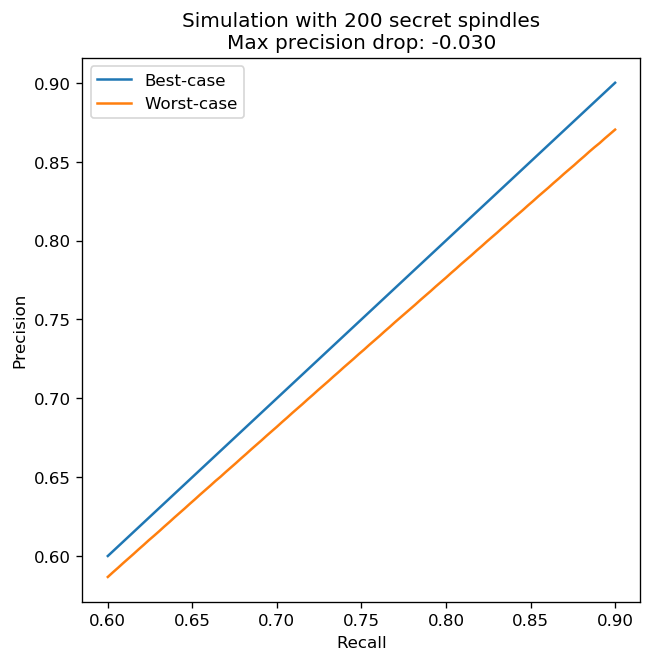

In [26]:
# Worst-case scenario: all the dangers are indeed a true spindle, making the nn likely to predict a spindle there
# but the annotation is imposed to be zero, so they will increase the number of FP unfairly
# In the worst-case, the system will predict all of them, and so all of them will contribute to FP
# This has an impact in precision
fp_extra_available = 200

op_points = np.linspace(0.6, 0.9, 100)
new_precisions = []
for op_point in op_points:
    # op_point = 0.8  # Recall = Precision
    tp = int(op_point * n_spindles)
    fp = int(tp * (1 - op_point) / op_point)
    fp_addition = int(fp_extra_available * op_point)
    new_precisions.append(tp / (tp + fp + fp_addition))
new_precisions = np.array(new_precisions)

plt.figure(figsize=(6, 6), dpi=120)
plt.title(
    "Simulation with %d secret spindles\nMax precision drop: -%1.3f" % (
        fp_extra_available, 
        op_points[-1] - new_precisions[-1]))
plt.plot(op_points, op_points, label='Best-case')
plt.plot(op_points, new_precisions, label='Worst-case')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

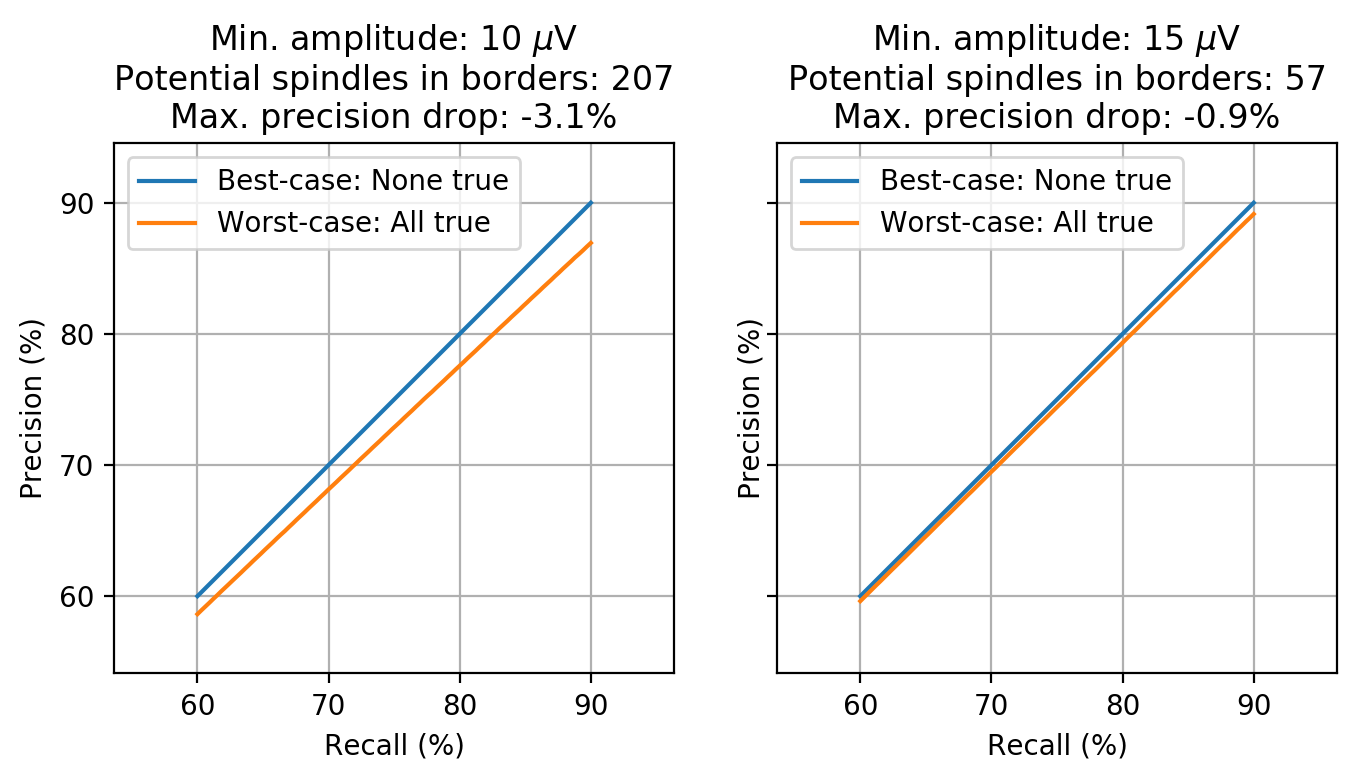

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4), dpi=200, sharex=True, sharey=True)
amp_thr = [10, 15]
for i, fp_extra_available in enumerate([207, 57]):
    op_points = np.linspace(0.6, 0.9, 100)
    new_precisions = []
    for op_point in op_points:
        # op_point = 0.8  # Recall = Precision
        tp = int(op_point * n_spindles)
        fp = int(tp * (1 - op_point) / op_point)
        fp_addition = int(fp_extra_available * op_point)
        new_precisions.append(tp / (tp + fp + fp_addition))
    new_precisions = np.array(new_precisions)
    ax[i].set_title(
        "Min. amplitude: %d $\mu$V\nPotential spindles in borders: %d\nMax. precision drop: -%1.1f%%" % (
            amp_thr[i],
            fp_extra_available, 
            100 * (op_points[-1] - new_precisions[-1])))
    ax[i].plot(100 * op_points, 100 * op_points, label='Best-case: None true')
    ax[i].plot(100 * op_points, 100 * new_precisions, label='Worst-case: All true')
    ax[i].set_xlabel("Recall (%)")
    ax[i].set_ylabel("Precision (%)")
    ax[i].set_aspect('equal')
    ax[i].legend()
    ax[i].set_xticks([60, 70, 80, 90])
    ax[i].set_yticks([60, 70, 80, 90])
    ax[i].grid()
plt.tight_layout()
plt.show()